# MATH306 Project
# IUS student eating habits and lifestyle
### Asja Basovic

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import re

In [2]:
df=pd.read_excel(r"C:\Users\Asja\Downloads\IUS student eating habits and lifestyle(1-70).xlsx")

## Data preprocessing

In [3]:
# these columns are not needed
df=df.drop(['ID', 'Start time', 'Completion time', 'Email', 'Name','Last modified time'], axis=1)

In [4]:
# renaming for cleaner code
column_aliases = {
    'What is your gender?': 'Gender',
    'What is your academic year?': 'Academic_Year',
    'What is your faculty?': 'Faculty',
    'What is your age?\xa0(numerical input; please write only the number, eg. 21)': 'Age',
    'Where do you eat the MAJORITY (over 50%) of your meals?': 'Primary_Food_Location',
    'Do you also regularly eat at any of these other locations?\xa0(Select all that apply)': 'Other_Food_Locations',
    'Do you generally eat breakfast daily?': 'Breakfast_Daily',
    'How many full meals (breakfast/lunch/dinner) do you usually eat per day?': 'Meals_Per_Day',
    'How many days per week do you eat a balanced meal (fruits, vegetables, protein)?': 'Balanced_Meals_Per_Week',
    'What caffeinated drink do you consume the most?': 'Primary_Caffeine',
    'On average, how many times per week do you drink this beverage?\xa0(Numerical input; please ) only write the number, eg. 2)': 'Caffeine_Frequency',
    'How many hours do you sleep per night on average?': 'Sleep_Hours',
    'Do you skip meals due to stress or a busy schedule?': 'Skip_Meals_Stress',
    'How stressed do you feel this semester?\xa0(Scale from 1 = Not stressed to 5 = Extremely stressed)': 'Stress_Level',
    'Do your eating habits change during exam periods?': 'Eating_Changes_Exams',
    'How often do you exercise per week (30+ minutes of physical activity)?': 'Exercise_Frequency',
    'Do you consider yourself physically active?': 'Physically_Active',
    "What’s your approximate weekly food budget?": 'Weekly_Food_Budget',
    "What’s the biggest factor affecting your diet?": 'Main_Diet_Factor'
}

df = df.rename(columns=column_aliases)

In [5]:
def convert_range_to_midpoint(value): # function that helps convert categorical columns to numerical
    if pd.isna(value):
        return value
    
    value_str = str(value).strip()
    
    # remove units like 'KM'
    value_str = re.sub(r'\s*[a-zA-Z]+\s*', '', value_str)
    value_str = value_str.strip()
    
    # handle <
    if value_str.startswith('<'):
        try:
            return float(value_str[1:])
        except ValueError:
            return value
    
    # handle +
    if value_str.endswith('+'):
        try:
            return float(value_str[:-1])
        except ValueError:
            return value
    
    # handle ranges (20-40)
    if '-' in value_str:
        parts = value_str.split('-')
        if len(parts) == 2:
            try:
                start = float(parts[0].strip())
                end = float(parts[1].strip())
                return (start + end) / 2
            except ValueError:
                return value
    if 'More than 3' in value:
            return 4
    
    # handle single numbers
    try:
        return float(value_str)
    except ValueError:
        return value

In [6]:
# handling the questions that had ranges as answeres, e.g '1-2', or '20-40 KM'
df['Sleep_Hours'] = df['Sleep_Hours'].apply(convert_range_to_midpoint)
df['Weekly_Food_Budget'] = df['Weekly_Food_Budget'].apply(convert_range_to_midpoint)
df['Exercise_Frequency'] = df['Exercise_Frequency'].apply(convert_range_to_midpoint)
df['Balanced_Meals_Per_Week'] = df['Balanced_Meals_Per_Week'].apply(convert_range_to_midpoint)
df['Meals_Per_Day'] = df['Meals_Per_Day'].apply(convert_range_to_midpoint)

In [7]:
df.head()

,Gender,Academic_Year,Faculty,Age,Primary_Food_Location,Other_Food_Locations,Breakfast_Daily,Meals_Per_Day,Balanced_Meals_Per_Week,Primary_Caffeine,Caffeine_Frequency,Sleep_Hours,Skip_Meals_Stress,Stress_Level,Eating_Changes_Exams,Exercise_Frequency,Physically_Active,Weekly_Food_Budget,Main_Diet_Factor
0,Female,Sophomore,FENS,20,Home (self/roommate cooked),Campus cafeteria;Home (self/roommate cooked);F...,Yes,3.0,1.5,Energy drinks,2,5.0,No,4,No,3.5,No,40–60 KM,Convenience
1,Female,Sophomore,FENS,21,Home (self/roommate cooked),Delivery apps;Fast food;,Yes,2.0,3.5,Coffee,15,5.0,No,5,No,1.5,No,60–80 KM,Convenience
2,Female,Senior,FENS,22,Home (self/roommate cooked),Campus cafeteria;Fast food;Sit-down restaurant...,Yes,2.0,3.5,Coffee,10,7.5,No,4,No,0.0,No,60–80 KM,If i have more free time I eat more sweets :)
3,Male,Senior,FENS,22,Home (self/roommate cooked),Home (self/roommate cooked);Campus cafeteria;,Yes,3.0,5.5,Coffee,15,7.5,Yes,5,No,3.5,Yes,30.0,Lack of time
4,Female,Senior,FENS,23,Home (self/roommate cooked),Campus cafeteria;Sit-down restaurants;Fast food;,Yes,2.0,3.5,Coffee,14,5.0,Yes,5,Yes,1.5,No,30.0,Lack of time


## EDA

In [8]:
df.describe()

,Age,Meals_Per_Day,Balanced_Meals_Per_Week,Caffeine_Frequency,Sleep_Hours,Stress_Level,Exercise_Frequency
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,21.071429,2.214286,3.735714,6.814286,6.528571,3.814286,2.128571
std,1.266302,0.678721,1.889562,6.295369,1.329394,1.067204,1.446349
min,18.000000,1.000000,0.000000,0.000000,5.000000,1.000000,0.000000
25%,20.000000,2.000000,1.500000,2.000000,5.000000,3.000000,1.500000
50%,21.000000,2.000000,3.500000,5.000000,7.500000,4.000000,1.500000
75%,22.000000,2.000000,5.500000,8.750000,7.500000,5.000000,3.500000
max,24.000000,4.000000,7.000000,29.000000,9.000000,5.000000,5.000000


In [9]:
df.isnull().sum() 
# the 9 nulls in Primary_Caffeine is when people answered 'None' as their primary caffeinated drink

Gender                     0
Academic_Year              0
Faculty                    0
Age                        0
Primary_Food_Location      0
Other_Food_Locations       0
Breakfast_Daily            0
Meals_Per_Day              0
Balanced_Meals_Per_Week    0
Primary_Caffeine           9
Caffeine_Frequency         0
Sleep_Hours                0
Skip_Meals_Stress          0
Stress_Level               0
Eating_Changes_Exams       0
Exercise_Frequency         0
Physically_Active          0
Weekly_Food_Budget         0
Main_Diet_Factor           0
dtype: int64

In [10]:
df['Primary_Caffeine']=df['Primary_Caffeine'].fillna('Nothing')

In [11]:
numerical_cols = ['Age', 'Meals_Per_Day', 'Caffeine_Frequency', 'Stress_Level', 
                 'Sleep_Hours_Numeric', 'Balanced_Meals_Numeric', 'Exercise_Frequency_Numeric',
                 'Weekly_Budget_Numeric']

print("Statistics Overview - Numerical variables")
for col in numerical_cols:
    if col in df.columns and not df[col].empty:
        data = df[col].dropna()
        if len(data) > 0:
            print(f"\n{col}:")
            print(f"  Mean: {data.mean():.2f}")
            print(f"  Median: {data.median():.2f}")
            print(f"  Mode: {data.mode().iloc[0] if not data.mode().empty else 'N/A'}")
            print(f"  Std Dev: {data.std():.2f}")
            print(f"  Variance: {data.var():.2f}")
            print(f"  Range: {data.max() - data.min():.2f}")
            print(f"  IQR: {data.quantile(0.75) - data.quantile(0.25):.2f}")

print("Statistics Overview - Categorical variables")
categorical_cols = ['Gender', 'Academic_Year', 'Faculty', 'Primary_Food_Location', 
                   'Primary_Caffeine', 'Breakfast_Daily', 'Skip_Meals_Stress', 
                   'Eating_Changes_Exams', 'Physically_Active', 'Main_Diet_Factor']

for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}:")
        value_counts = df[col].value_counts()
        proportions = df[col].value_counts(normalize=True) * 100
        
        for value, count in value_counts.items():
            prop = proportions[value]
            print(f"  {value}: {count} ({prop:.1f}%)")



Statistics Overview - Numerical variables

Age:
  Mean: 21.07
  Median: 21.00
  Mode: 21
  Std Dev: 1.27
  Variance: 1.60
  Range: 6.00
  IQR: 2.00

Meals_Per_Day:
  Mean: 2.21
  Median: 2.00
  Mode: 2.0
  Std Dev: 0.68
  Variance: 0.46
  Range: 3.00
  IQR: 0.00

Caffeine_Frequency:
  Mean: 6.81
  Median: 5.00
  Mode: 2
  Std Dev: 6.30
  Variance: 39.63
  Range: 29.00
  IQR: 6.75

Stress_Level:
  Mean: 3.81
  Median: 4.00
  Mode: 4
  Std Dev: 1.07
  Variance: 1.14
  Range: 4.00
  IQR: 2.00
Statistics Overview - Categorical variables

Gender:
  Female: 39 (55.7%)
  Male: 30 (42.9%)
  Prefer not to say: 1 (1.4%)

Academic_Year:
  Sophomore: 40 (57.1%)
  Senior: 15 (21.4%)
  Freshman: 9 (12.9%)
  Junior: 6 (8.6%)

Faculty:
  FENS: 45 (64.3%)
  FASS: 17 (24.3%)
  FBA: 8 (11.4%)

Primary_Food_Location:
  Home (self/roommate cooked): 57 (81.4%)
  Campus cafeteria: 6 (8.6%)
  Fast food: 3 (4.3%)
  Delivery apps: 2 (2.9%)
  Sit-down restaurants: 2 (2.9%)

Primary_Caffeine:
  Coffee: 30 (42.9%)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   70 non-null     object 
 1   Academic_Year            70 non-null     object 
 2   Faculty                  70 non-null     object 
 3   Age                      70 non-null     int64  
 4   Primary_Food_Location    70 non-null     object 
 5   Other_Food_Locations     70 non-null     object 
 6   Breakfast_Daily          70 non-null     object 
 7   Meals_Per_Day            70 non-null     float64
 8   Balanced_Meals_Per_Week  70 non-null     float64
 9   Primary_Caffeine         70 non-null     object 
 10  Caffeine_Frequency       70 non-null     int64  
 11  Sleep_Hours              70 non-null     float64
 12  Skip_Meals_Stress        70 non-null     object 
 13  Stress_Level             70 non-null     int64  
 14  Eating_Changes_Exams     70 

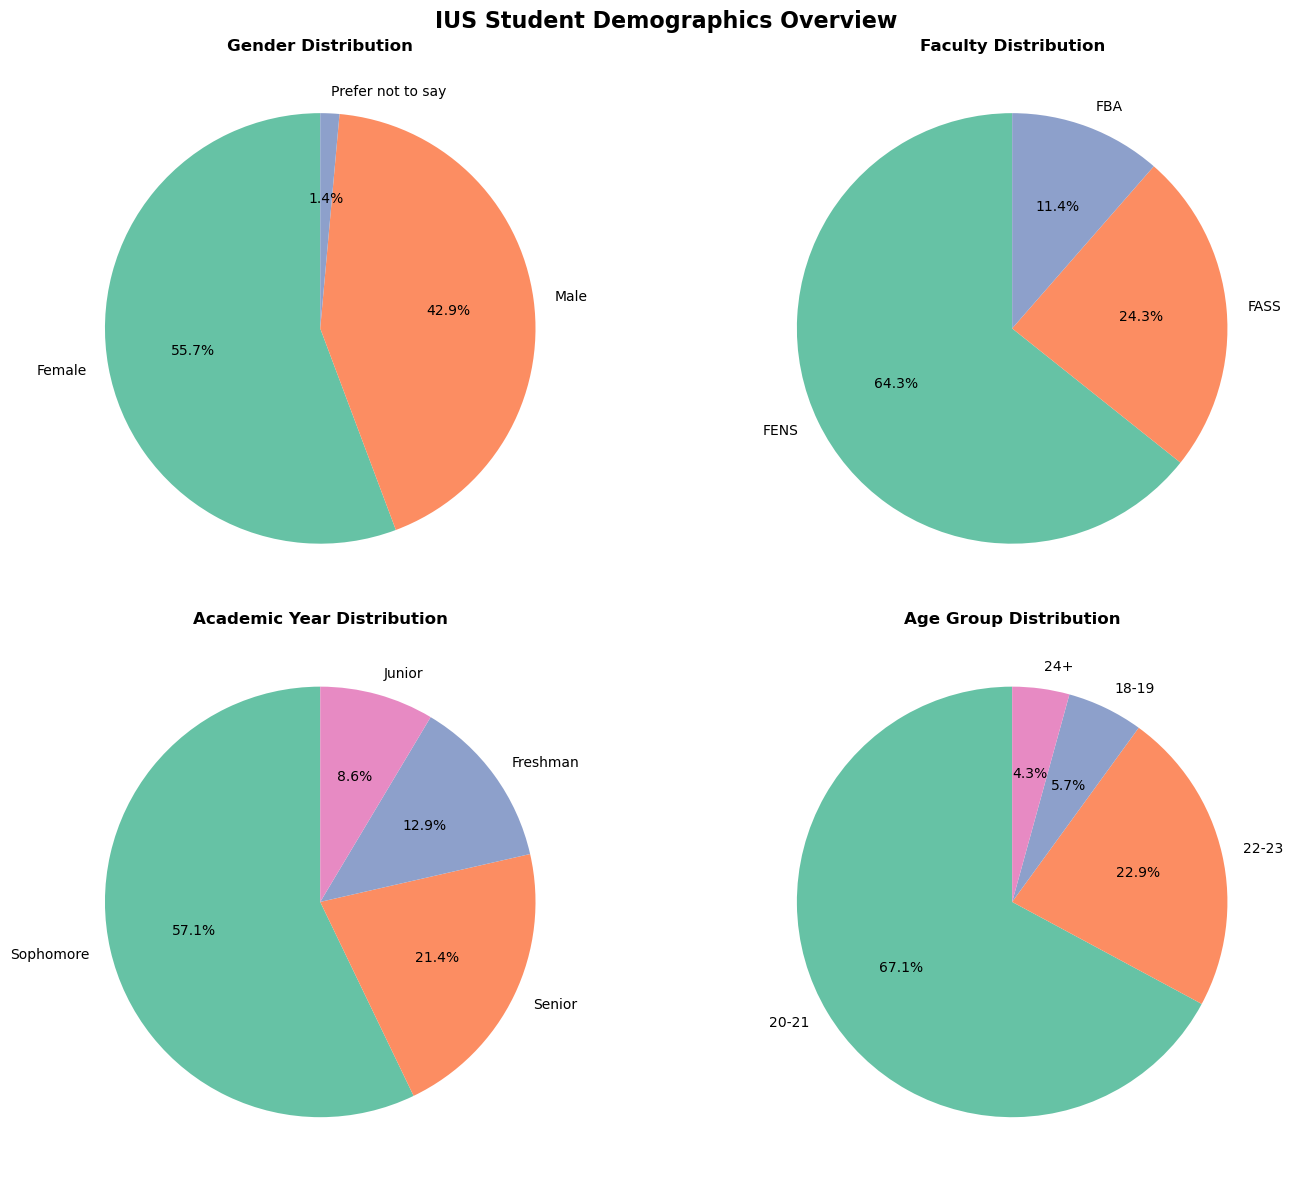

In [13]:
# visualization of the sample demographics (gender, faculty, academic year, age)
sns.set_palette("Set2")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('IUS Student Demographics Overview', fontsize=16, fontweight='bold')

gender_counts = df['Gender'].value_counts()
axes[0, 0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Gender Distribution', fontweight='bold')

faculty_counts = df['Faculty'].value_counts()
axes[0, 1].pie(faculty_counts.values, labels=faculty_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Faculty Distribution', fontweight='bold')

year_counts = df['Academic_Year'].value_counts()
axes[1, 0].pie(year_counts.values, labels=year_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title('Academic Year Distribution', fontweight='bold')

age_bins = [18, 20, 22, 24, 30]
age_labels = ['18-19', '20-21', '22-23', '24+']
df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)
age_group_counts = df['Age_Group'].value_counts()
axes[1, 1].pie(age_group_counts.values, labels=age_group_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Age Group Distribution', fontweight='bold')

plt.tight_layout()
plt.show()

## Hypothesis tests

### Hypothesis 1 (one sample t-test)

In [14]:
print("HYPOTHESIS 1: STUDENT STRESS LEVEL VS MODERATE STRESS")

# H0: Mean stress level = 3.0 (moderate stress on 1-5 scale)
# H1: Mean stress level ≠ 3.0

stress_column = 'Stress_Level'
stress_data = df[stress_column].dropna().astype(float)
print(f"Sample size: n = {len(stress_data)}")
print(f"Sample mean: {stress_data.mean():.2f} (on 1-5 scale)")
print(f"Sample SD: {stress_data.std():.2f}")
print(f"Population mean (moderate stress): 3.0")

t_stat5, p_value5 = stats.ttest_1samp(stress_data, 3.0)
print(f"\nOne-sample t-test results:")
print(f"t-statistic: {t_stat5:.4f}")
print(f"p-value (two-tailed): {p_value5:.4f}")
print(f"Effect size (Cohen's d): {abs(stress_data.mean() - 3.0) / stress_data.std():.4f}")

if p_value5 < 0.05:
    if stress_data.mean() > 3.0:
        print("RESULT: SIGNIFICANT - IUS students report significantly HIGHER stress than moderate level!")
    else:
        print("RESULT: SIGNIFICANT - IUS students report significantly LOWER stress than moderate level!")
else:
    print("RESULT: NOT SIGNIFICANT")

HYPOTHESIS 1: STUDENT STRESS LEVEL VS MODERATE STRESS
Sample size: n = 70
Sample mean: 3.81 (on 1-5 scale)
Sample SD: 1.07
Population mean (moderate stress): 3.0

One-sample t-test results:
t-statistic: 6.3838
p-value (two-tailed): 0.0000
Effect size (Cohen's d): 0.7630
RESULT: SIGNIFICANT - IUS students report significantly HIGHER stress than moderate level!


Text(0.5, 1.0, 'Stress Level Distribution')

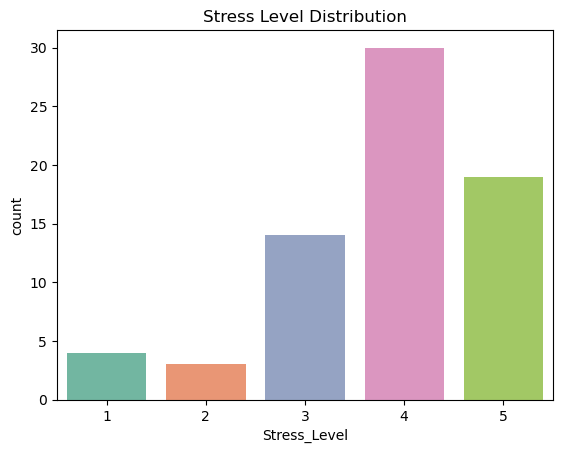

In [15]:
sns.countplot(x='Stress_Level', data=df)
plt.title('Stress Level Distribution')

### Hypothesis 2 (two sample t-test)

In [16]:
print("HYPOTHESIS 2: STRESS LEVEL AND MEAL SKIPPING")

# H0: No difference in stress levels between meal skippers and non-skippers
# H1: Meal skippers have higher stress levels than non-skippers

stress_data = df[df['Stress_Level'].notna() & df['Skip_Meals_Stress'].notna()]

skippers_stress = stress_data[stress_data['Skip_Meals_Stress'] == 'Yes']['Stress_Level']
non_skippers_stress = stress_data[stress_data['Skip_Meals_Stress'] == 'No']['Stress_Level']

print(f"Meal skippers (n={len(skippers_stress)}): Mean stress = {skippers_stress.mean():.2f}, SD = {skippers_stress.std():.2f}")
print(f"Non-skippers (n={len(non_skippers_stress)}): Mean stress = {non_skippers_stress.mean():.2f}, SD = {non_skippers_stress.std():.2f}")

t_stat1, p_value1_two_tailed = stats.ttest_ind(skippers_stress, non_skippers_stress, equal_var=False)
p_value1_one_tailed = p_value1_two_tailed / 2

print(f"\nTwo-sample t-test results:")
print(f"t-statistic: {t_stat1:.4f}")
print(f"p-value (one-tailed): {p_value1_one_tailed:.4f}")

if p_value1_one_tailed < 0.05:
    print("RESULT: SIGNIFICANT - Meal skippers have significantly higher stress levels!")
else:
    print("RESULT: NOT SIGNIFICANT")

HYPOTHESIS 2: STRESS LEVEL AND MEAL SKIPPING
Meal skippers (n=45): Mean stress = 4.09, SD = 0.76
Non-skippers (n=25): Mean stress = 3.32, SD = 1.35

Two-sample t-test results:
t-statistic: 2.6318
p-value (one-tailed): 0.0064
RESULT: SIGNIFICANT - Meal skippers have significantly higher stress levels!


<Axes: xlabel='Skip_Meals_Stress', ylabel='Stress_Level'>

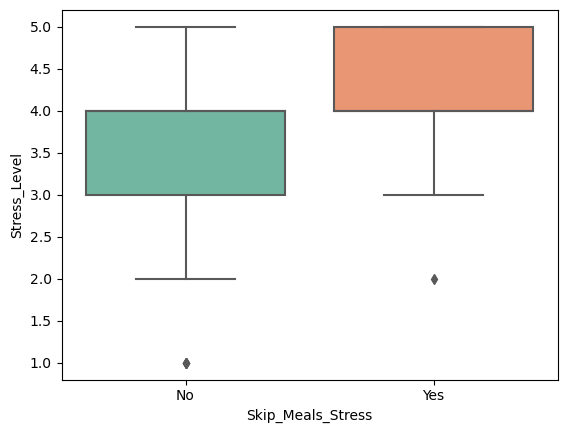

In [17]:
sns.boxplot(x='Skip_Meals_Stress', y='Stress_Level', data=df)

### Hypothesis 3 (two sample t-test)

In [18]:
print("HYPOTHESIS 3: GENDER DIFFERENCES IN STRESS LEVELS")

# H0: No difference in stress levels between males and females
# H1: Significant difference exists

gender_column = 'Gender'
stress_column = 'Stress_Level'

stress_gender_data = df[(df[gender_column].isin(['Male', 'Female'])) & (df[stress_column].notna())]
male_stress = stress_gender_data[stress_gender_data[gender_column] == 'Male'][stress_column].astype(float)
female_stress = stress_gender_data[stress_gender_data[gender_column] == 'Female'][stress_column].astype(float)

print(f"Male stress levels (n={len(male_stress)}): Mean = {male_stress.mean():.2f}, SD = {male_stress.std():.2f}")
print(f"Female stress levels (n={len(female_stress)}): Mean = {female_stress.mean():.2f}, SD = {female_stress.std():.2f}")

t_stat_stress, p_val_stress = stats.ttest_ind(male_stress, female_stress, equal_var=False)

print(f"\nTwo-sample t-test:")
print(f"t-statistic: {t_stat_stress:.4f}")
print(f"p-value: {p_val_stress:.4f}")

if p_val_stress < 0.05:
    if female_stress.mean() > male_stress.mean():
        print("SIGNIFICANT: Females report significantly HIGHER stress than males!")
    else:
        print("SIGNIFICANT: Males report significantly HIGHER stress than females!")
else:
    print("NOT SIGNIFICANT")

HYPOTHESIS 3: GENDER DIFFERENCES IN STRESS LEVELS
Male stress levels (n=30): Mean = 3.57, SD = 1.17
Female stress levels (n=39): Mean = 4.08, SD = 0.84

Two-sample t-test:
t-statistic: -2.0279
p-value: 0.0479
SIGNIFICANT: Females report significantly HIGHER stress than males!


Text(0.5, 1.0, 'Stress level distribution according to gender')

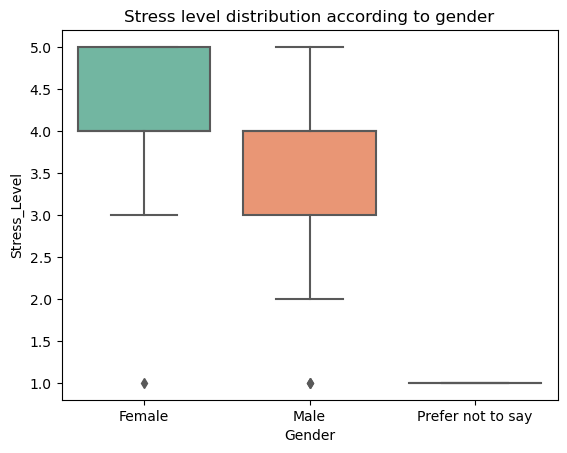

In [19]:
sns.boxplot(x='Gender', y='Stress_Level', data=df)
plt.title('Stress level distribution according to gender')

### Hypothesis 4 (one sample propotion test)

In [20]:
print("HYPOTHESIS 4: BREAKFAST SKIPPING RATE")

# H0: Proportion of students who skip breakfast = 0.234 (same as young adults nationally)
# H1: Proportion ≠ 0.234

breakfast_column = 'Breakfast_Daily'
breakfast_data = df[breakfast_column].dropna()
breakfast_no = (breakfast_data == 'No').sum()
breakfast_total = len(breakfast_data)
breakfast_prop = breakfast_no / breakfast_total

print(f"Students who skip breakfast: {breakfast_no}/{breakfast_total} ({breakfast_prop:.3f})")
print(f"Expected proportion (national avg): 0.300")

z_stat1, p_value1 = proportions_ztest(breakfast_no, breakfast_total, 0.234)
print(f"\nOne-proportion z-test:")
print(f"z-statistic: {z_stat1:.4f}")
print(f"p-value: {p_value1:.4f}")

if p_value1 < 0.05:
    if breakfast_prop > 0.3:
        print("SIGNIFICANT: IUS students skip breakfast MORE than national average!")
    else:
        print("SIGNIFICANT: IUS students skip breakfast LESS than national average!")
else:
    print("NOT SIGNIFICANT")

HYPOTHESIS 4: BREAKFAST SKIPPING RATE
Students who skip breakfast: 36/70 (0.514)
Expected proportion (national avg): 0.300

One-proportion z-test:
z-statistic: 4.6920
p-value: 0.0000
SIGNIFICANT: IUS students skip breakfast MORE than national average!


Text(0.5, 1.0, 'Do IUS students eat breakfast daily?')

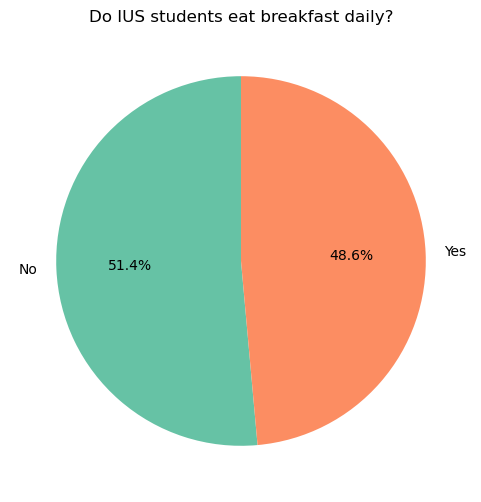

In [21]:
breakfast_counts = df['Breakfast_Daily'].value_counts()
labels = breakfast_counts.index
sizes = breakfast_counts.values

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Do IUS students eat breakfast daily?')